In [57]:
import pandas as pd
import numpy as np
import random
import re
from faker import Faker
from utils import CampaignDataset
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [58]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
fake = Faker()
Faker.seed(SEED)

# Select campaign_id
CAMPAIGN_ID = 303

# Set the click conversion rate
CLICK_CONVERSION = 0.07

rcParams["font.family"] = "Arial"


In [59]:
# Load the dataset

path = "campaign_performance.xlsx"

df_campaigns = pd.read_excel(path,sheet_name="campaigns")
df_metrics = pd.read_excel(path, sheet_name="campaign_metrics")
df_transactions = pd.read_excel(path, sheet_name="transactions")

## Subjective Preferences

In [60]:
preferences = {
    "Generation Z": {
        "Age Range": (18, 27),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.2, 0.1], # Probability to buy = 20%, spending deviation=10%
                "Health and Beauty": [0.15, 0.1],  
                "Electronics": [0.65, 0.2],  
            },
            "Female": {
                "Groceries": [0.25, 0.1],
                "Health and Beauty": [0.6, 0.15],  
                "Electronics": [0.15, 0.1],
            },
        },
    },
    "Millennials": {
        "Age Range": (28, 40),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.3, 0.15],
                "Health and Beauty": [0.2, 0.2],
                "Electronics": [0.5, 0.25],
            },
            "Female": {
                "Groceries": [0.35, 0.2],
                "Health and Beauty": [0.45, 0.2],
                "Electronics": [0.2, 0.15],
            },
        },
    },
    "Generation X": {
        "Age Range": (41, 55),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.4, 0.2],
                "Health and Beauty": [0.25, 0.15],
                "Electronics": [0.35, 0.3],
            },
            "Female": {
                "Groceries": [0.45, 0.25],
                "Health and Beauty": [0.35, 0.2],
                "Electronics": [0.2, 0.15],
            },
        },
    },
    "Boomers": {
        "Age Range": (56, 65),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.5, 0.3],
                "Health and Beauty": [0.35, 0.2],
                "Electronics": [0.15, 0.1],
            },
            "Female": {
                "Groceries": [0.55, 0.3],
                "Health and Beauty": [0.3, 0.2],
                "Electronics": [0.15, 0.1],
            },
        },
    },
}

age_distribution = [
        (18, 19, 7.36), 
        (20, 24, 8.68),
        (25, 29, 8.92),
        (30, 34, 6.97),
        (35, 39, 6.91),
        (40, 44, 5.15),
        (45, 49, 4.16),
        (50, 54, 2.99),
        (55, 59, 2.42),
        (60, 65, 1.83) 
    ]

dow_weights = {
            0: 0.9,  # Monday
            1: 0.95, # Tuesday
            2: 1.0,  # Wednesday
            3: 1.0,  # Thursday
            4: 1.1,  # Friday
            5: 1.3,  # Saturday
            6: 1.2   # Sunday
        }

In [62]:
# Setup the dataset class
campaign_dataset = CampaignDataset(df_campaigns=df_campaigns,
                                   df_metrics=df_metrics,
                                   df_transactions=df_transactions,
                                   )

# Simulate the daily metrics and interpolate the transactions
campaign_dataset.simulate_daily_metrics(CAMPAIGN_ID, dow_weights)
extrapolated_transaction = campaign_dataset.generate_synthetic_transactions(CAMPAIGN_ID, preferences, age_distribution, CLICK_CONVERSION)

In [63]:
daily_metrics = campaign_dataset.daily_metrics

#Click Through Ratio (CTR) is clicks divided by impressions
daily_metrics["CTR"] = daily_metrics["daily_clicks"]/daily_metrics["daily_impressions"]

# Joining the dataset
grouped_transactions = extrapolated_transaction.groupby(by=["campaign_id", "transaction_date"]).count()[["transaction_id"]].rename(columns={"transaction_id":"unique_transactions"})

daily_campaign_data = pd.merge(daily_metrics, grouped_transactions, how="left", left_on=["campaign_id", "date"], right_on=["campaign_id", "transaction_date"])

# Click Through Ratio (CTR) is clicks divided by impressions
daily_metrics["CTR"] = daily_metrics["daily_clicks"]/daily_metrics["daily_impressions"]

# Conversion Rate is number of unique transactions divided by daily clicks
daily_campaign_data["conversion_rate"] = daily_campaign_data["unique_transactions"] / daily_campaign_data["daily_clicks"]

# Bounce rate is assumed to be (daily web hits - daily clicks) divided by the daily web hits
daily_campaign_data["bounce_rate"] = (daily_campaign_data["daily_web_hits"] - daily_campaign_data["daily_clicks"]) / daily_campaign_data["daily_web_hits"]

daily_campaign_data

,campaign_id,date,daily_web_hits,daily_impressions,daily_clicks,CTR,unique_transactions,conversion_rate,bounce_rate
0,303,2024-03-01,3340,4115,186,0.045200,13,0.069892,0.944311
1,303,2024-03-02,3681,4867,348,0.071502,30,0.086207,0.905460
2,303,2024-03-03,3643,4491,408,0.090848,27,0.066176,0.888004
3,303,2024-03-04,2732,3423,225,0.065732,17,0.075556,0.917643
4,303,2024-03-05,2884,3554,225,0.063309,15,0.066667,0.921983
5,303,2024-03-06,3036,3639,276,0.075845,17,0.061594,0.909091
6,303,2024-03-07,3036,3776,138,0.036547,9,0.065217,0.954545
7,303,2024-03-08,3340,4104,242,0.058967,15,0.061983,0.927545
8,303,2024-03-09,3947,4855,364,0.074974,30,0.082418,0.907778
9,303,2024-03-10,3643,4512,372,0.082447,22,0.059140,0.897886


## Campaign Performance

### Correlation Analysis

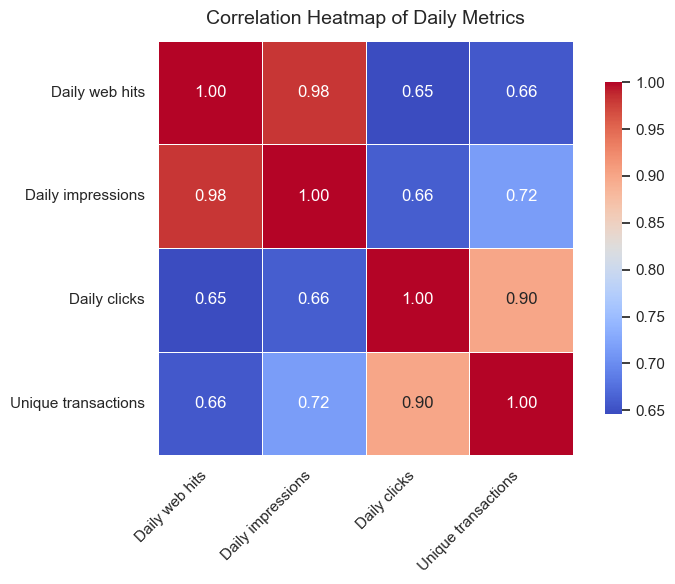

In [64]:
# Defining the relevant columns
relevant_cols = ["daily_web_hits", "daily_impressions", "daily_clicks", "unique_transactions"]
daily_metrics = daily_campaign_data[relevant_cols]

sns.set_theme(style="white")

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size for readability
heatmap = sns.heatmap(      # Setting up the heatmap
    daily_metrics.corr(),
    annot=True,            
    fmt=".2f",              
    cmap="coolwarm",        
    linewidths=0.5,        
    square=True,            
    cbar_kws={"shrink": 0.8} 
)


plt.title("Correlation Heatmap of Daily Metrics", fontsize=14, pad=12)

# Formatting the labels
format_labels = lambda x: x.replace("_"," ").capitalize()

heatmap.set_xticklabels([format_labels(label.get_text()) for label in heatmap.get_xticklabels()], rotation=45, ha="right")
heatmap.set_yticklabels([format_labels(label.get_text()) for label in heatmap.get_yticklabels()], rotation=0)

plt.tight_layout()
plt.show()

### Cost Effectiveness (CPC and ROI)

In [ ]:
# Get relevant columns
relevant_cols = ["campaign_id", "budget", "Clicks", "Impressions", "website_landing_hits", "total_transaction_amount","aov","total_unique_transactions"]

# Get the metrics and campaign data
campaign_metrics = campaign_dataset._merge_campaigns_and_metrics()

# Get the total campaign transactions
total_campaign_transactions = extrapolated_transaction.groupby(by="campaign_id").agg(
    total_transaction_amount=("amount","sum"),
    aov = ("amount", "mean"),
    total_unique_transactions=("transaction_id","count")
).reset_index()

# Join the two datasets
campaign_metrics_transactions = pd.merge(left=campaign_metrics, right=total_campaign_transactions, how="inner", on="campaign_id")[relevant_cols]

# Marketing Cost per Transaction is budget divided by total unique transactions
campaign_metrics_transactions["CPT"] = campaign_metrics_transactions["budget"] / campaign_metrics_transactions["total_unique_transactions"]

# ROI assuming average profit of 10%
profit_margin = .1
campaign_metrics_transactions["Profit"] = ((campaign_metrics_transactions["total_transaction_amount"] * profit_margin) - campaign_metrics_transactions["budget"])
campaign_metrics_transactions["ROI"] =  campaign_metrics_transactions["Profit"]/(
                                        campaign_metrics_transactions["budget"] + (campaign_metrics_transactions["total_transaction_amount"] * (1-profit_margin))
                                        )
campaign_metrics_transactions["CPT/AOV"] = campaign_metrics_transactions["CPT"] / campaign_metrics_transactions['aov']
campaign_metrics_transactions

,campaign_id,budget,Clicks,Impressions,website_landing_hits,total_transaction_amount,aov,total_unique_transactions,CPT,Profit,ROI,CPT/AOV
0,303,6000,4000,60000,48310,80760,287.402135,281,21.352313,2076.0,0.026384,0.074294


### Cost Effectiveness (Bounce Rates)

In [66]:
# Get the average bounce rate
avg_bounce_rate = daily_campaign_data["bounce_rate"].mean()

print(f"Average bounce rate during the campaign: {avg_bounce_rate*100:.2f}%")

Average bounce rate during the campaign: 91.78%


### Profit for each transaction

In [67]:
# Calculate the profit / loss which is (transaction amount * profit margin) - marketing cost per transaction
extrapolated_transaction["profit"] = (extrapolated_transaction["amount"] * profit_margin) - campaign_metrics_transactions["CPT"].iloc[0]
extrapolated_transaction

,campaign_id,transaction_id,amount,transaction_date,customer_id,gender,age,product_category,profit
0,303,4,500,2024-03-10,caac8e8d-0680-4664-a5b3-370e85d28e66,Male,63,Groceries,28.647687
1,303,6,333,2024-03-01,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Male,28,Electronics,11.947687
2,303,7,391,2024-03-01,23b8c1e9-3924-46de-beb1-3b9046685257,Female,40,Health and Beauty,17.747687
3,303,8,213,2024-03-01,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Female,29,Health and Beauty,-0.052313
4,303,9,248,2024-03-01,972a8469-1641-4f82-8b9d-2434e465e150,Male,47,Groceries,3.447687
...,...,...,...,...,...,...,...,...,...
276,303,281,331,2024-03-15,d5385b0e-34f3-493c-8ff0-a55c6a702e2f,Male,18,Electronics,11.747687
277,303,282,166,2024-03-15,a9ba5a27-907b-4e36-9786-48f864de82e6,Female,57,Groceries,-4.752313
278,303,283,147,2024-03-15,6db99102-a48b-4dbe-957d-94a106f028ff,Male,39,Electronics,-6.652313
279,303,284,84,2024-03-15,2e85cb21-7631-4e9d-9de9-f86322bd3388,Female,18,Electronics,-12.952313


# Customer Insights

### Customer Segmentation

In [68]:
# Get all ages defined in preferences
ages_in_pref = []
for generation in preferences.keys():
    ages_in_pref.extend(list(preferences[generation]["Age Range"]))

# Set the upper and lower limit of the ages
age_range = range(min(ages_in_pref), max(ages_in_pref)+1)

generations = []
for age in age_range:
    for generation in preferences.keys():
        if preferences[generation]["Age Range"][0] <= age <= preferences[generation]["Age Range"][1]:
            generations.append(generation)

generations_df = pd.DataFrame({"age":age_range, "generation":generations})

extrapolated_transaction_gen = pd.merge(left=extrapolated_transaction, right=generations_df, how="left", on="age")
extrapolated_transaction_gen

,campaign_id,transaction_id,amount,transaction_date,customer_id,gender,age,product_category,profit,generation
0,303,4,500,2024-03-10,caac8e8d-0680-4664-a5b3-370e85d28e66,Male,63,Groceries,28.647687,Boomers
1,303,6,333,2024-03-01,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Male,28,Electronics,11.947687,Millennials
2,303,7,391,2024-03-01,23b8c1e9-3924-46de-beb1-3b9046685257,Female,40,Health and Beauty,17.747687,Millennials
3,303,8,213,2024-03-01,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Female,29,Health and Beauty,-0.052313,Millennials
4,303,9,248,2024-03-01,972a8469-1641-4f82-8b9d-2434e465e150,Male,47,Groceries,3.447687,Generation X
...,...,...,...,...,...,...,...,...,...,...
276,303,281,331,2024-03-15,d5385b0e-34f3-493c-8ff0-a55c6a702e2f,Male,18,Electronics,11.747687,Generation Z
277,303,282,166,2024-03-15,a9ba5a27-907b-4e36-9786-48f864de82e6,Female,57,Groceries,-4.752313,Boomers
278,303,283,147,2024-03-15,6db99102-a48b-4dbe-957d-94a106f028ff,Male,39,Electronics,-6.652313,Millennials
279,303,284,84,2024-03-15,2e85cb21-7631-4e9d-9de9-f86322bd3388,Female,18,Electronics,-12.952313,Generation Z


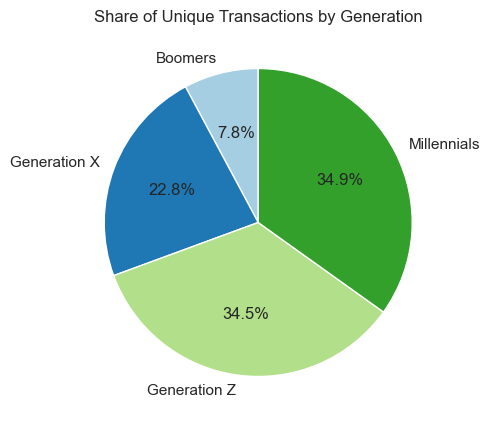

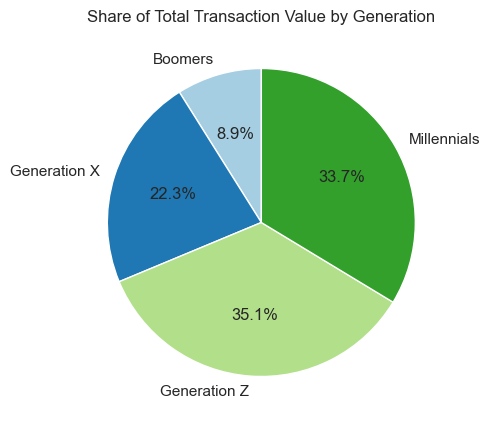

In [69]:
# group by 'generation' to calculate required metrics
grouped = extrapolated_transaction_gen.groupby('generation').agg(
    transaction_count=('transaction_id', 'count'),  # count transactions
    total_amount=('amount', 'sum')                 # sum transaction amounts
)

# reset index for easier access
grouped = grouped.reset_index()

def generate_pie_chart(ref_df,values,labels, title):
    plt.figure(figsize=(10, 5))
    plt.pie(
        ref_df[values],
        labels=ref_df[labels],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors,
    )
    plt.title(title)
    plt.show()

generate_pie_chart(grouped, "transaction_count", "generation", "Share of Unique Transactions by Generation")
generate_pie_chart(grouped, "total_amount", "generation", "Share of Total Transaction Value by Generation")



In [82]:
def format_age_labels(age):
    ages = re.findall(r"\d+", age)
    return f"{ages[0]} - {ages[1]}"

def plot_pareto(ref_df, x_axis, y_axis, aggr, xlabel, ylabel, title, interval=False):
    # create age bins with a custom interval
    bin_col = x_axis
    
    if interval:
        bin_col = f'{x_axis}_bin'
        bin_edges = np.arange(ref_df[x_axis].min(), ref_df[x_axis].max() + interval, interval)  # intervals of interval
        ref_df[bin_col] = pd.cut(ref_df[x_axis], bins=bin_edges, right=False)

    # group by age bins to calculate the number of transactions
    grouped = ref_df.groupby(bin_col).agg(
        yaxis=(y_axis, aggr)
    ).reset_index()

    # sort by transaction count in descending order
    grouped = grouped.sort_values(by='yaxis', ascending=False)

    # calculate cumulative percentage
    grouped['cumulative_percentage'] = grouped['yaxis'].cumsum() / grouped['yaxis'].sum() * 100

    # create the pareto chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # bar chart for transaction count
    ax.bar(grouped[bin_col].astype(str), grouped['yaxis'], color='skyblue', label=ylabel)

    # line chart for cumulative percentage
    ax2 = ax.twinx()  # secondary y-axis
    ax2.plot(grouped[bin_col].astype(str), grouped['cumulative_percentage'], color='orange', marker='o', label='Cumulative %')


    # add labels and formatting
    ax.set_xlabel(xlabel, fontsize=12)
    if interval:
        ax.set_xticklabels(grouped[bin_col].astype(str).apply(format_age_labels))
    else:
        ax.set_xticklabels(grouped[bin_col])

    ax.set_ylabel(ylabel, fontsize=12)
    ax2.set_ylabel('Cumulative Percentage', fontsize=12)
    ax2.set_ylim(0, 110)  # to extend the line beyond 100%
    ax.set_title(title, fontsize=14)

    # add grid and legend
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # display the chart
    plt.tight_layout()
    plt.show()

C:\Users\nachm\AppData\Local\Temp\ipykernel_12856\1079315114.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped[bin_col].astype(str).apply(format_age_labels))


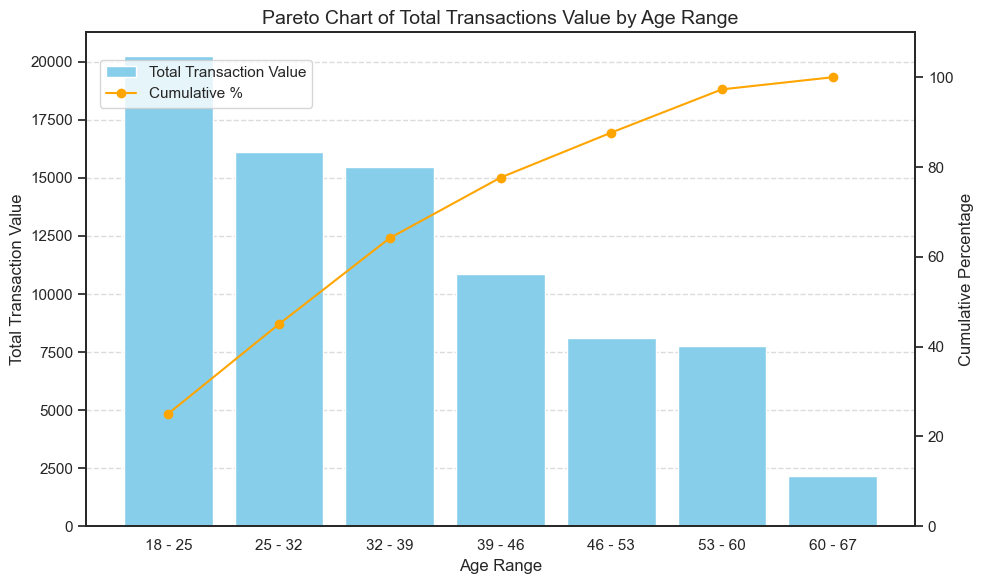

C:\Users\nachm\AppData\Local\Temp\ipykernel_12856\1079315114.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped[bin_col].astype(str).apply(format_age_labels))


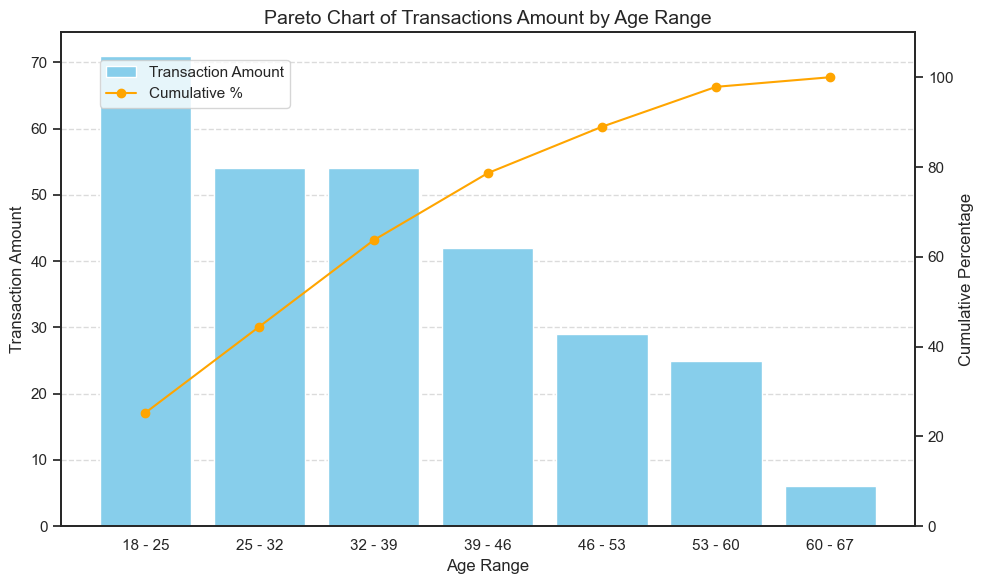

In [83]:
plot_pareto(extrapolated_transaction_gen,x_axis="age",y_axis="amount", aggr='sum', xlabel="Age Range", ylabel="Total Transaction Value", title="Pareto Chart of Total Transactions Value by Age Range",interval=7)
plot_pareto(extrapolated_transaction_gen,x_axis="age",y_axis="transaction_id", aggr='count', xlabel="Age Range", ylabel="Transaction Amount", title="Pareto Chart of Transactions Amount by Age Range",interval=7)

C:\Users\nachm\AppData\Local\Temp\ipykernel_12856\1079315114.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped[bin_col])


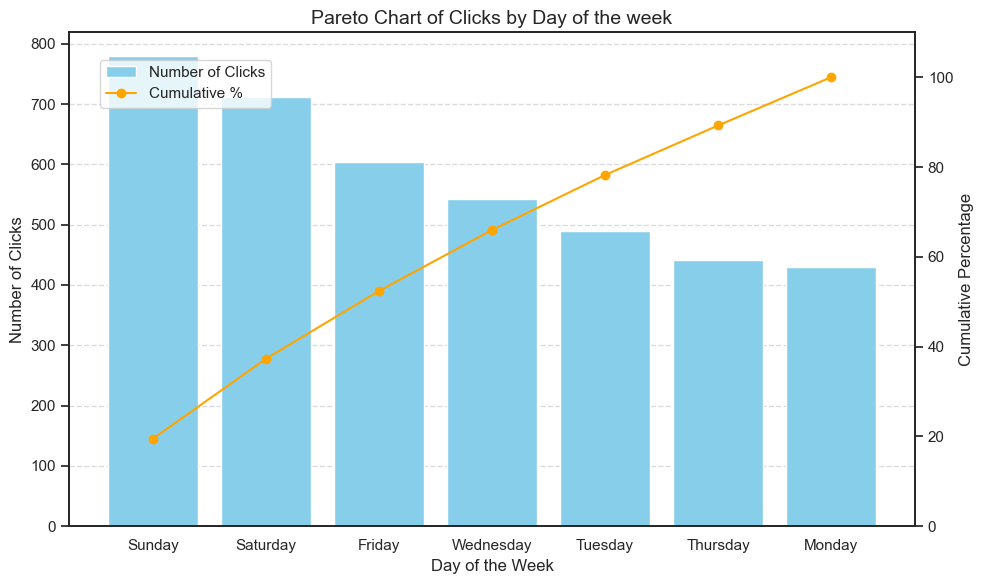

In [88]:
daily_campaign_data["Day"] = daily_campaign_data["date"].dt.day_name()
plot_pareto(daily_campaign_data,
            x_axis="Day",
            y_axis="daily_clicks", 
            aggr='sum', 
            xlabel="Day of the Week", 
            ylabel="Number of Clicks", 
            title="Pareto Chart of Clicks by Day of the week")


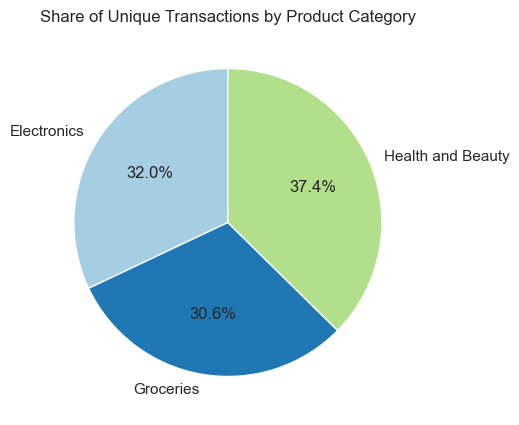

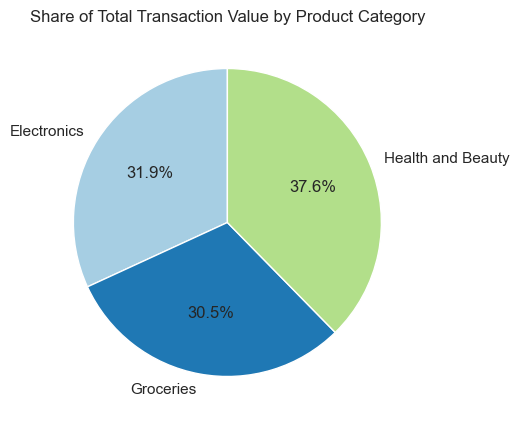

In [15]:
# group by 'generation' to calculate required metrics
grouped = extrapolated_transaction_gen.groupby("product_category").agg(
    transaction_count=('transaction_id', 'count'),  # count transactions
    total_amount=('amount', 'sum')                 # sum transaction amounts
)

# reset index for easier access
grouped = grouped.reset_index()

generate_pie_chart(grouped, "transaction_count", "product_category", "Share of Unique Transactions by Product Category")
generate_pie_chart(grouped, "total_amount", "product_category", "Share of Total Transaction Value by Product Category")


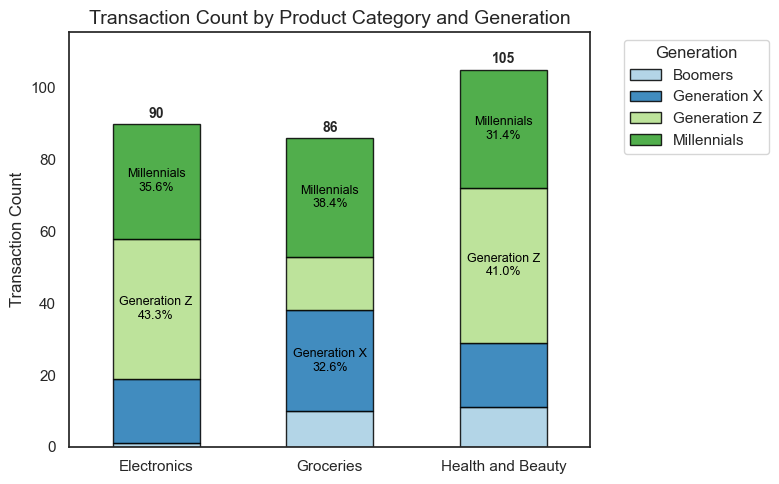

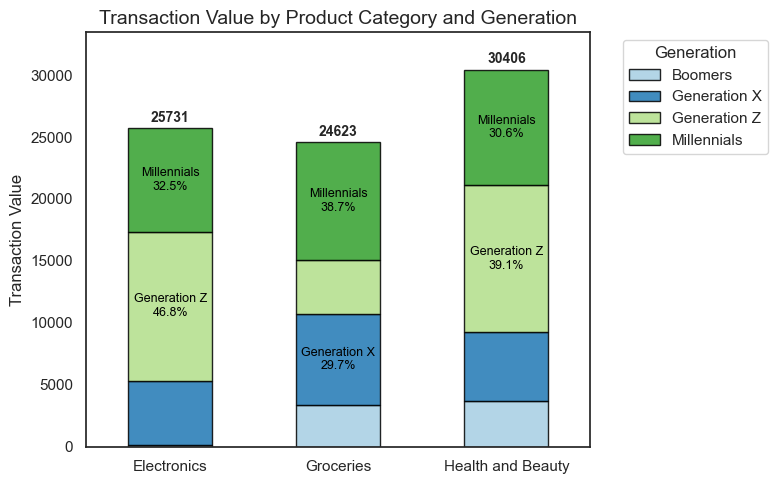

In [16]:
# Aggregate data
grouped_nested = extrapolated_transaction_gen.groupby(['product_category', 'generation']).agg(
    transaction_count=('transaction_id', 'count'),  # Count transactions
    total_amount=('amount', 'sum')                 # Sum transaction amounts
).reset_index()

# Stacking the data
transaction_count_data = grouped_nested.pivot(
    index='product_category',
    columns='generation',
    values='transaction_count'
).fillna(0)

transaction_amount_data = grouped_nested.pivot(
    index='product_category',
    columns='generation',
    values='total_amount'
).fillna(0)

# Define a plotting function
def plot_stacked_bar_with_top_percentages(data, title, ylabel, annotate_total=True):
    # Define color palette
    colors = plt.cm.Paired.colors[:len(data.columns)]

    # Plot the stacked bars
    ax = data.plot(
        kind='bar',
        stacked=True,
        color=colors,
        figsize=(8, 5),
        alpha=0.85,
        edgecolor='black'
    )

    # Add labels for top 2 contributing generations
    for i, category in enumerate(data.index):
        total = data.loc[category].sum()

        # Calculate y_offset for each product category
        y_offset = 0
        for gen in data.columns:
            value = data.loc[category, gen]
            percentage = (value / total) * 100 if total > 0 else 0

            # Check if the gen is top 2
            sorted_generations = data.loc[category].sort_values(ascending=False)
            top_2_generations = sorted_generations.head(2)
            if gen in top_2_generations.index and value > 0:
                # Annotate the bar
                text_y = y_offset + value / 2
                plt.text(
                    i, text_y,  
                    f"{gen}\n{percentage:.1f}%",  
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='black'
                )

            # Update cumulative offset
            y_offset += value

        # Add total value above each bar
        if annotate_total:
            plt.text(
            i, total + total * 0.01,  
            f"{total:.0f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    
    plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("\n", fontsize=12)
    plt.ylim(0, data.loc[category].sum().max() + (data.loc[category].sum().max()*0.1))
    plt.xticks(rotation='horizontal')
    plt.legend(title="Generation", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot transaction count
plot_stacked_bar_with_top_percentages(
    data=transaction_count_data,
    title="Transaction Count by Product Category and Generation",
    ylabel="Transaction Count"
)

# Plot transaction value
plot_stacked_bar_with_top_percentages(
    data=transaction_amount_data,
    title="Transaction Value by Product Category and Generation",
    ylabel="Transaction Value"
)

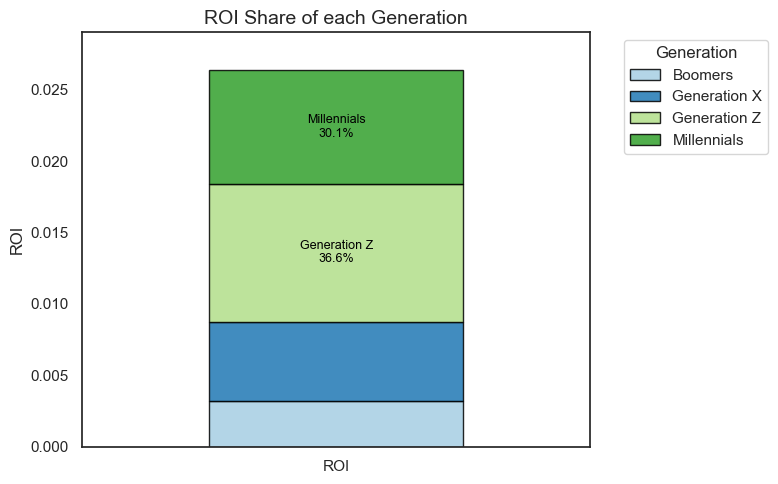

In [17]:
relevant_cols = ["generation", "ROI"]
grouped_nested = extrapolated_transaction_gen.groupby(['generation']).agg(
    total_profit=('profit', 'sum'),
    total_unique_transactions = ('transaction_id', 'count'),
    transaction_total = ('amount', 'sum')
).reset_index()

grouped_nested["transaction_cost"] = (grouped_nested["transaction_total"] * (1-profit_margin))

grouped_nested["ROI"] = grouped_nested["total_profit"]/(grouped_nested["transaction_cost"].sum()+campaign_metrics_transactions["budget"].iloc[0])
grouped_nested[relevant_cols]

pivoted = grouped_nested.set_index("generation")['ROI'].to_frame().T
pivoted.index = ["ROI"]

plot_stacked_bar_with_top_percentages(data=pivoted,title="ROI Share of each Generation",ylabel="ROI", annotate_total=False)

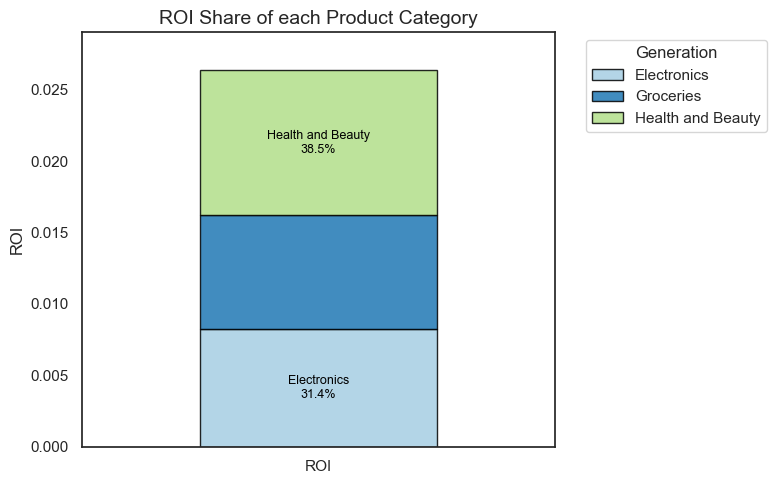

In [18]:
relevant_cols = ["product_category", "ROI"]
grouped_nested = extrapolated_transaction_gen.groupby(['product_category']).agg(
    total_profit=('profit', 'sum'),
    total_unique_transactions = ('transaction_id', 'count'),
    transaction_total = ('amount', 'sum')
).reset_index()

grouped_nested["transaction_cost"] = (grouped_nested["transaction_total"] * (1-profit_margin))

grouped_nested["ROI"] = grouped_nested["total_profit"]/(grouped_nested["transaction_cost"].sum()+campaign_metrics_transactions["budget"].iloc[0])
grouped_nested[relevant_cols]

pivoted = grouped_nested.set_index("product_category")['ROI'].to_frame().T
pivoted.index = ["ROI"]

plot_stacked_bar_with_top_percentages(data=pivoted,title="ROI Share of each Product Category",ylabel="ROI", annotate_total=False)

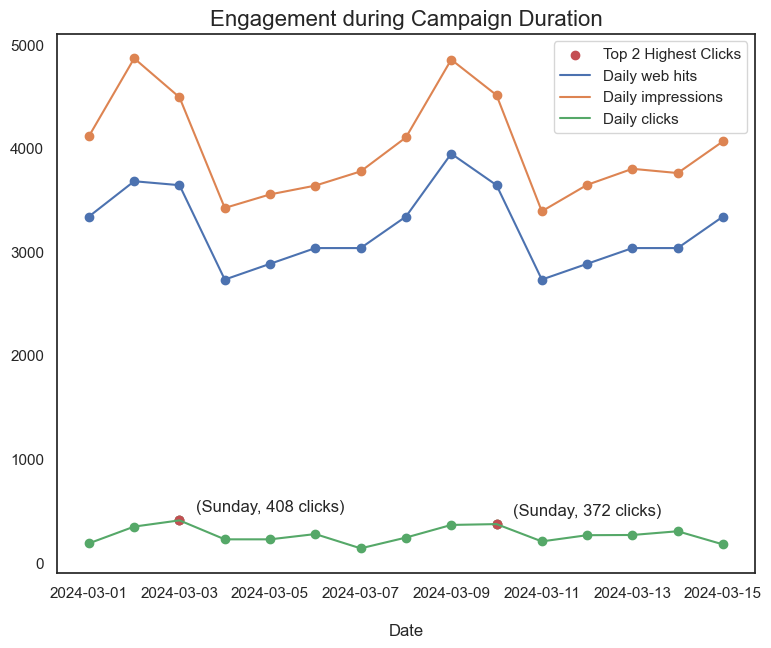

In [52]:
def plot_timeseries(ref_df, x_axis, y_axis, label):
    plt.scatter(ref_df[x_axis], ref_df[y_axis])
    plt.plot(ref_df[x_axis], ref_df[y_axis], label=label)

# Identify the top 2 days with maximum clicks
top_clicks = daily_campaign_data.nlargest(2, 'daily_clicks')
top_clicks['day_of_week'] = top_clicks['date'].dt.day_name()  # Add day of the week


# Columns to plot
plot_cols = ["daily_web_hits", "daily_impressions", "daily_clicks"]

plt.figure(figsize=(9, 7))

# Plot the top 2 highest clicks using scatter plot
plt.scatter(top_clicks['date'], top_clicks['daily_clicks'], c='r', label="Top 2 Highest Clicks")

# Plot timeseries
for col in plot_cols:
    plot_timeseries(
        ref_df=daily_campaign_data,
        x_axis='date',
        y_axis=col,
        label=col.replace("_", " ").capitalize()
    )

plt.scatter(top_clicks['date'], top_clicks['daily_clicks'])
# Annotate top 2 points for daily clicks
for _, row in top_clicks.iterrows():
    plt.annotate(
        f"({row['day_of_week']}, {row['daily_clicks']} clicks)",  # Display clicks and day of the week
        xy=(row['date'], row['daily_clicks']),  # Coordinates of the point
        xytext=(row['date'] + pd.Timedelta(days=2), row['daily_clicks'] + .22 * row['daily_clicks']),  # Annotation placed above
        ha='center',
        fontsize=12,
    )

plt.title('Engagement during Campaign Duration', fontsize=16)
plt.xlabel("\nDate")
plt.legend()
plt.show()


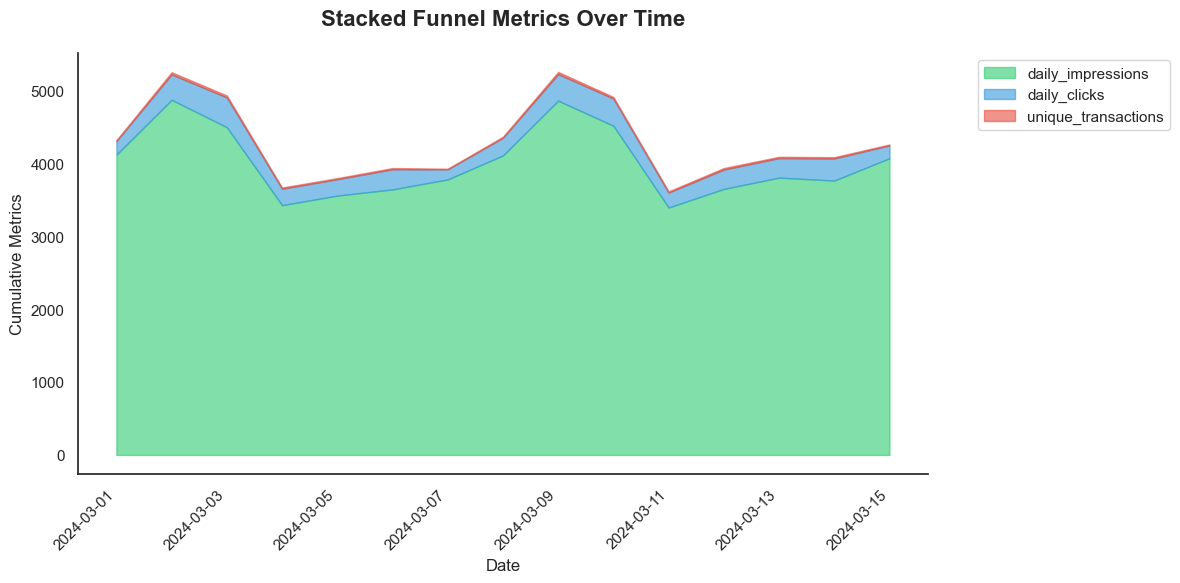

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_stacked_timeseries_funnel(df, date_column, metric_columns):
    """
    Create a stacked time series funnel chart showing multiple metrics over time.

    Parameters:
    df: DataFrame containing the data
    date_column: Name of the date column
    metric_columns: List of metric columns to plot, in funnel order (top to bottom)
    """
    # Prepare the data for stacking
    stacked_data = df[metric_columns].cumsum(axis=1)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color palette
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6']
    
    # Plot each metric as a stacked area
    for idx, metric in enumerate(metric_columns):
        # Define the base and the top of the stacked area
        if idx == 0:
            base = np.zeros_like(df[metric])  # Base starts at zero for the first metric
        else:
            base = stacked_data.iloc[:, idx - 1]  # Base is the cumulative sum of previous metrics
        
        ax.fill_between(
            df[date_column], 
            base, 
            stacked_data[metric],
            color=colors[idx % len(colors)], 
            alpha=0.6, 
            label=metric
        )
    
    # Customize the plot
    ax.set_title('Stacked Funnel Metrics Over Time', pad=20, fontsize=16, fontweight='bold')
    ax.set_ylabel('Cumulative Metrics')
    ax.set_xlabel('Date')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

# Example usage:

# Assuming daily_campaign_data has columns: 'date', 'daily_impressions', 'daily_clicks', 'unique_transactions'
metric_columns = ['daily_impressions', 'daily_clicks', 'unique_transactions']

fig = plot_stacked_timeseries_funnel(
    df=daily_campaign_data,
    date_column='date',
    metric_columns=metric_columns
)
plt.show()
 

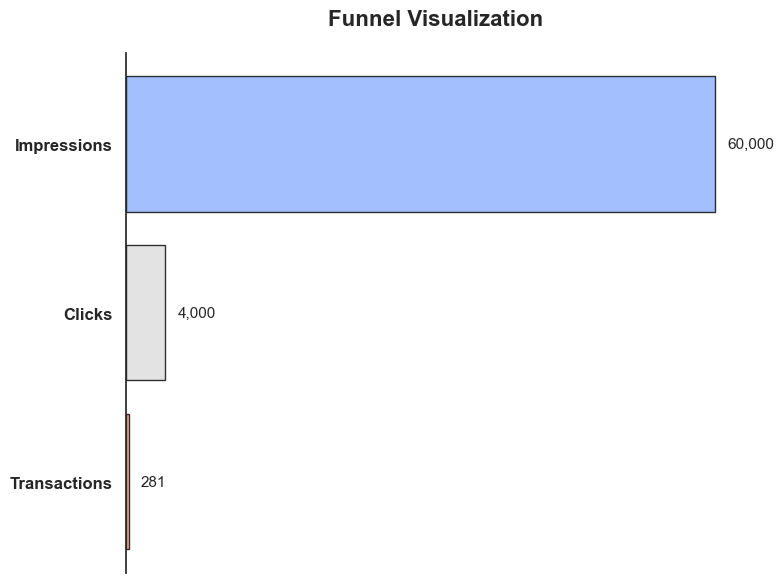

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_funnel_chart(stage_names, stage_values, mod_labels):
    """
    Create a funnel visualization chart.
    
    Parameters:
    - stage_names: List of stage names (e.g., ['Impressions', 'Clicks', 'Transactions'])
    - stage_values: List of corresponding values for each stage
    """
    # Ensure data is sorted by funnel progression
    stage_values = sorted(stage_values, reverse=True)
    
    # Colors for the funnel
    colors = sns.color_palette("coolwarm", len(stage_names))
    
    # Calculate width of each stage as a proportion of the largest stage
    max_value = max(stage_values)
    widths = [value / max_value for value in stage_values]
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot each stage as a horizontal bar
    for i, (stage, value, width) in enumerate(zip(stage_names, stage_values, widths)):
        ax.barh(i, width, color=colors[i], alpha=0.8, edgecolor='black', label=f"{stage}: {value:,.0f}")
    
    # Formatting
    ax.set_yticks(range(len(stage_names)))
    ax.set_yticklabels(stage_names, fontsize=12, fontweight='bold')
    if mod_labels:
        labels = mod_labels.values()
        ax.set_yticklabels(labels, fontsize=12, fontweight='bold')
            
    ax.invert_yaxis()  # Highest stage at the top
    ax.set_xlim(0, 1.05)  # Slight padding
    ax.set_title("Funnel Visualization", fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks([])  # Remove x-axis ticks
    
    # Add value labels to the bars
    for i, value in enumerate(stage_values):
        ax.text(widths[i] + 0.02, i, f"{value:,.0f}", va='center', fontsize=11)
    
    # Add legend
    # ax.legend(loc='lower right', labels=labels if mod_labels else stage_names)
    
    # Remove spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

# Example Usage
stage_names = ['Impressions', 'Clicks', 'total_unique_transactions']
labels = ['Impressions', 'Clicks', 'Transactions']
stage_values = campaign_metrics_transactions[stage_names].values.tolist()[0]

plot_funnel_chart(stage_names, stage_values, dict(zip(stage_names,labels)))


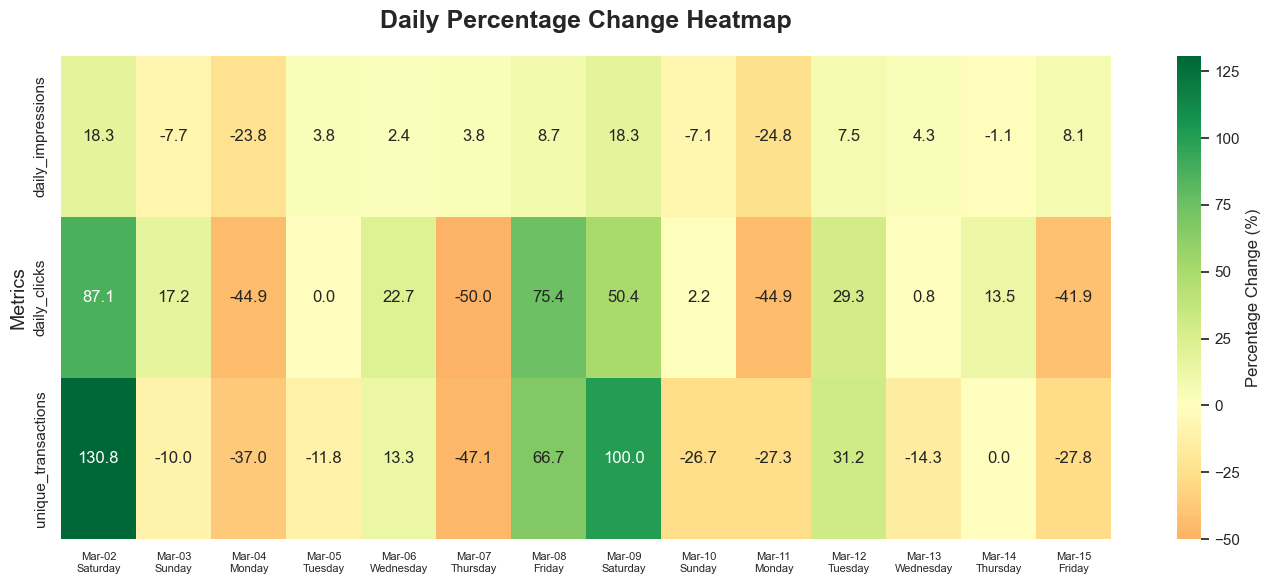

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def plot_percentage_change_heatmap(df, date_column, metric_columns):
    """
    Create a heatmap showing percentage changes for multiple metrics over time,
    with "Campaign Started" annotation for the first period.
    
    Parameters:
    - df: DataFrame containing the data
    - date_column: Name of the column containing dates
    - metric_columns: List of metric columns to compute percentage changes
    """
    # Calculate percentage changes for the metrics
    percentage_changes = df[metric_columns].pct_change() * 100  # Convert to percentage
    percentage_changes[date_column] = df[date_column]
    
    # Reshape the DataFrame for a heatmap-friendly format
    heatmap_data = percentage_changes.set_index(date_column).T
    heatmap_data = heatmap_data[heatmap_data.columns[1:]] 
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(14, 6))
  
    # Create the heatmap
    sns.heatmap(
        heatmap_data[heatmap_data.columns],
        annot=True,  
        fmt=".1f",  # Remove format to allow both text and numbers
        cmap="RdYlGn",
        linewidths=0,
        linecolor=None,
        center=0,
        cbar_kws={"label": "Percentage Change (%)"},
        ax=ax
    )
    
    # Format the x-axis to show month and day only
    ax.set_xticklabels([f"{date.strftime('%b-%d')}\n{date.strftime('%A')}" for date in heatmap_data.columns], rotation=0, ha='center', fontsize=8)
    
    ax.set_title("Daily Percentage Change Heatmap", fontsize=18, pad=20, fontweight='bold')
    ax.set_xlabel(None)
    ax.set_ylabel("Metrics", fontsize=14)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_percentage_change_heatmap(daily_campaign_data, date_column="date", metric_columns=["daily_impressions", "daily_clicks", "unique_transactions"])